## Attach Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Custom Gen

In [0]:
"""Fairly basic set of tools for real-time data augmentation on image data.
Can easily be extended to include new transformations,
new preprocessing methods, etc...
"""
#from __future__ import absolute_import
#from __future__ import print_function

import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
from six.moves import range
import os
import threading
import warnings
import multiprocessing.pool
from functools import partial
from sklearn.utils import shuffle
import keras.backend as K
import matplotlib.pyplot as plt
import cv2

try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None


def random_rotation(x, rg, row_axis=1, col_axis=2, channel_axis=0,
                    fill_mode='nearest', cval=0.):
    """Performs a random rotation of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        rg: Rotation range, in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Rotated Numpy image tensor.
    """
    theta = np.pi / 180 * np.random.uniform(-rg, rg)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shift of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        wrg: Width shift range, as a float fraction of the width.
        hrg: Height shift range, as a float fraction of the height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Shifted Numpy image tensor.
    """
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shear(x, intensity, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shear of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        intensity: Transformation intensity.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Sheared Numpy image tensor.
    """
    shear = np.random.uniform(-intensity, intensity)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_zoom(x, zoom_range, row_axis=1, col_axis=2, channel_axis=0,
                fill_mode='nearest', cval=0.):
    """Performs a random spatial zoom of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        zoom_range: Tuple of floats; zoom range for width and height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Zoomed Numpy image tensor.
    # Raises
        ValueError: if `zoom_range` isn't a tuple.
    """
    if len(zoom_range) != 2:
        raise ValueError('`zoom_range` should be a tuple or list of two floats. '
                         'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_channel_shift(x, intensity, channel_axis=0):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.
    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.
    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])


def img_to_array(img, data_format=None):
    """Converts a PIL Image instance to a Numpy array.
    # Arguments
        img: PIL Image instance.
        data_format: Image data format.
    # Returns
        A 3D Numpy array.
    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x


def load_img(path, grayscale=False, target_size=None):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size:
        hw_tuple = (target_size[1], target_size[0])
        if img.size != hw_tuple:
            img = img.resize(hw_tuple)
    return img


def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f)]


class ImageDataGeneratorCustom(object):
    
    """Generate minibatches of image data with real-time data augmentation.
    # Arguments
        featurewise_center: set input mean to 0 over the dataset.
        samplewise_center: set each sample mean to 0.
        featurewise_std_normalization: divide inputs by std of the dataset.
        samplewise_std_normalization: divide each input by its std.
        zca_whitening: apply ZCA whitening.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        rotation_range: degrees (0 to 180).
        width_shift_range: fraction of total width.
        height_shift_range: fraction of total height.
        shear_range: shear intensity (shear angle in radians).
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range.
        channel_shift_range: shift range for each channels.
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'.
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally.
        vertical_flip: whether to randomly flip images vertically.
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided. This is
            applied after the `preprocessing_function` (if any provided)
            but before any other transformation.
        preprocessing_function: function that will be implied on each input.
            The function will run before any other modification on it.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: 'channels_first' or 'channels_last'. In 'channels_first' mode, the channels dimension
            (the depth) is at index 1, in 'channels_last' mode it is at index 3.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    """

    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None):
        if data_format is None:
            data_format = K.image_data_format()
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.zca_epsilon = zca_epsilon
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('`data_format` should be `"channels_last"` (channel after row and '
                             'column) or `"channels_first"` (channel before row and column). '
                             'Received arg: ', data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('`zoom_range` should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)

    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpg'):
        return NumpyArrayIterator(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def flow_from_directory(self, directory,triplet_path,
                            target_size=(256, 256), color_mode='grayscale',
                            classes=None, class_mode='categorical',
                            batch_size=32, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='jpg',
                            follow_links=False
                            ):
        
        return DirectoryIterator(
            directory, self,triplet_path,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.
        # Arguments
            x: batch of inputs to be normalized.
        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_axis = self.channel_axis - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_axis, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_axis, keepdims=True) + 1e-7)

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + 1e-7)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, x.shape)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x, seed=None):
        """Randomly augment a single image tensor.
        # Arguments
            x: 3D tensor, single image.
            seed: random seed.
        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        if seed is not None:
            np.random.seed(seed)

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)

        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)

        return x

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Fits internal statistics to some sample data.
        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        # Arguments
            x: Numpy array, the data to fit on. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        # Raises
            ValueError: in case of invalid input `x`.
        """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            warnings.warn(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' + self.data_format + '" '
                '(channels on axis ' + str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' + str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' + str(x.shape) +
                ' (' + str(x.shape[self.channel_axis]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)
        print ('HI')
        x = np.copy(x)
        if augment:
            ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + self.zca_epsilon))), u.T)


class Iterator(object):
    """Abstract base class for image data iterators.
    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed,triplet_path):
        count = 0
        f = open(triplet_path)
        f_read = f.read()
        for line in f_read.split('\n'):
            if len(line)>1:
                count += 1
        f.close()
        self.n = count #* 3#n
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(self.n, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):
    """Iterator yielding data from a Numpy array.
    # Arguments
        x: Numpy array of input data.
        y: Numpy array of targets data.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, x, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png'):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
        if self.x.shape[channels_axis] not in {1, 3, 4}:
            warnings.warn('NumpyArrayIterator is set to use the '
                          'data format convention "' + data_format + '" '
                          '(channels on axis ' + str(channels_axis) + '), i.e. expected '
                          'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
                          'However, it was passed an array with shape ' + str(self.x.shape) +
                          ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]), dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            x = self.image_data_generator.random_transform(x.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y
      
def _count_valid_files_in_directory_new(directory, triplet_path):
    """Count files with extension in `white_list_formats` contained in a directory.
    # Arguments
        directory: absolute path to the directory containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
    # Returns
        the count of files with extension in `white_list_formats` contained in
        the directory.
    """
    f = open(triplet_path)
    f_read = f.read()
    triplets = f_read.split('\n')
    f.close()
    return (len(triplets))
      
def _count_valid_files_in_directory(directory, white_list_formats, follow_links, triplet_path):
    """Count files with extension in `white_list_formats` contained in a directory.
    # Arguments
        directory: absolute path to the directory containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
    # Returns
        the count of files with extension in `white_list_formats` contained in
        the directory.
    """
    f = open(triplet_path)
    f_read = f.read()
    triplets = f_read.split('\n')
    f.close()
    return (len(triplets))


def _list_valid_filenames_in_directory(directory, white_list_formats,
                                       class_indices, follow_links,triplet_path):
    """List paths of files in `subdir` relative from `directory` whose extensions are in `white_list_formats`.
    # Arguments
        directory: absolute path to a directory containing the files to list.
            The directory name is used as class label and must be a key of `class_indices`.
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
        class_indices: dictionary mapping a class name to its index.
    # Returns
        classes: a list of class indices
        filenames: the path of valid files in `directory`, relative from
            `directory`'s parent (e.g., if `directory` is "dataset/class1",
            the filenames will be ["class1/file1.jpg", "class1/file2.jpg", ...]).
    """
    def _recursive_list(subpath):
        f = open(triplet_path)
        f_read = f.read()
        triplets = f_read.split('\n')
        f.close()
        filenames = triplets
#         for i in triplets:
#           filenames += [i]
        filenames = shuffle(filenames, random_state = 0)
        to_return_tuple= tuple()
        to_return_tuple = (os.path.abspath(subpath),[],filenames,)
        return [to_return_tuple]
        
    classes = []
    filenames = []
    subdir = os.path.basename(directory)
    basedir = os.path.dirname(directory)
    for root, _, files in _recursive_list(directory):
        for fname in files:
            is_valid = False
#             print (fname)
            for extension in white_list_formats:
                if fname.lower().endswith('.' + extension):
                    is_valid = True
                    break
            if is_valid:
#                 __, filename = os.path.split(fname)
                current_class = fname.split('/')[-2]
                classes.append(class_indices[current_class])
                # add filename relative to directory
                absolute_path = fname#os.path.join(root, fname)
                filenames.append(absolute_path)
            else:
                print (fname+" is not valid")
    print (len(classes))            
    return classes, filenames


class DirectoryIterator(Iterator):
    """Iterator capable of reading images from a directory on disk.
    # Arguments
        directory: Path to the directory to read images from.
            Each subdirectory in this directory will be
            considered to contain images from one class,
            or alternatively you could specify class subdirectories
            via the `classes` argument.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        target_size: tuple of integers, dimensions to resize input images to.
        color_mode: One of `"rgb"`, `"grayscale"`. Color mode to read images.
        classes: Optional list of strings, names of subdirectories
            containing images from each class (e.g. `["dogs", "cats"]`).
            It will be computed automatically if not set.
        class_mode: Mode for yielding the targets:
            `"binary"`: binary targets (if there are only two classes),
            `"categorical"`: categorical targets,
            `"sparse"`: integer targets,
            `"input"`: targets are images identical to input images (mainly
                used to work with autoencoders),
            `None`: no targets get yielded (only input images are yielded).
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, directory, image_data_generator,triplet_path,
                 target_size=(256, 256), color_mode='grayscale',
                 classes=None, class_mode='binary',
                 batch_size=32, shuffle=True, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png',
                 follow_links=False):
        if data_format is None:
            data_format = K.image_data_format()
        self.directory = directory
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        if color_mode not in {'rgb', 'grayscale'}:
            raise ValueError('Invalid color mode:', color_mode,
                             '; expected "rgb" or "grayscale".')
        self.color_mode = color_mode
        self.data_format = data_format
        if self.color_mode == 'rgb':
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (3,)
            else:
                self.image_shape = (3,) + self.target_size
        else:
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (1,)
            else:
                self.image_shape = (1,) + self.target_size
        self.classes = classes
        if class_mode not in {'categorical', 'binary', 'sparse',
                              'input', None}:
            raise ValueError('Invalid class_mode:', class_mode,
                             '; expected one of "categorical", '
                             '"binary", "sparse", "input"'
                             ' or None.')
        self.class_mode = class_mode
#         print (self.class_mode)
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'}

        # first, count the number of samples and classes
        self.samples = 0

        if not classes:
            classes = []
            for subdir in sorted(os.listdir(directory)):
                if os.path.isdir(os.path.join(directory, subdir)):
                    classes.append(subdir)
        self.num_class = len(classes)
        self.class_indices = dict(zip(classes, range(len(classes))))
        print (self.class_indices)
        pool = multiprocessing.pool.ThreadPool()
        self.samples = _count_valid_files_in_directory(directory,
                                                      white_list_formats=white_list_formats,
                                                       follow_links=follow_links,
                                                      triplet_path = triplet_path)
#         function_partial = partial(_count_valid_files_in_directory,
#                                    white_list_formats=white_list_formats,
#                                    follow_links=follow_links)
#         self.samples = sum(pool.map(function_partial,
#                                     (triplet_path)
#                                      for subdir in classes)))

        print('Found %d images belonging to %d classes.' % (self.samples, self.num_class))

        # second, build an index of the images in the different class subfolders
        results = []

        self.filenames = []
        self.classes = []
        print (self.samples)
#         self.classes = np.zeros((batch_size,), dtype='int32')
        i = 0
#         for dirpath in (os.path.join(directory, subdir) for subdir in classes):
        results.append(pool.apply_async(_list_valid_filenames_in_directory,
                                        (directory, white_list_formats,
                                         self.class_indices, follow_links,triplet_path)))
        for res in results:
            classes, filenames = res.get()
#             print (classes)
#             print (filenames)
            #self.classes = np.zeros((len(filenames),), dtype='int32')
            #self.classes[i:i + len(classes)] = classes
            self.filenames += filenames
            self.classes += classes
            i += len(classes)
        pool.close()
        pool.join()
        print (len(filenames), len(classes))
        
        super(DirectoryIterator, self).__init__(self.samples, batch_size, shuffle, seed, triplet_path)

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros((current_batch_size,) + self.image_shape, dtype=K.floatx())
        grayscale = self.color_mode == 'grayscale'
        # build batch of image data
#         print (index_array)
        files = [self.filenames[j] for j in index_array]
#         print (files)
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = load_img(fname,grayscale=grayscale,target_size=self.target_size)
            x = img_to_array(img, data_format=self.data_format)
#             print (x.shape)
            (thresh, temp) = cv2.threshold(x, 32, 255, cv2.THRESH_BINARY)
#             plt.imshow(x)
#             plt.show()
#             x = 255 - x
#             print (x)
            x[:,:,0] = temp
#             plt.imshow(x)
#             plt.show()
            x = self.image_data_generator.random_transform(x)
#             print (x)
            x = self.image_data_generator.standardize(x)
#             print (x)
            batch_x[i] = x
        # optionally save augmented images to disk for debugging purposes
#         if 0 in index_array:
#             self.save_to_dir = "/content/sample_data/"
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index ,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
#         self.save_to_dir = None
                #         print (self.classes)
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
#             batch_y = self.classes[index_array].astype(K.floatx())
#               print (index_array)
              batch_y = [self.classes[i] for i in index_array]
              batch_y_np = np.array(batch_y)
              batch_y = batch_y_np.astype(K.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())
            for x in range(len(batch_x)):
#             for i, label in enumerate(self.classes):
                label = self.classes[index_array[x]]
#                 print (files[index_array[x]], x, label)
                batch_y[x, label] = 1.
        else:
            return batch_x
        return ([batch_x, batch_y], [batch_y, batch_x])

## Model

### Extra function

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import csv
import math
import pandas

def plot_log(filename, show=True):

    data = pandas.read_csv(filename)

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for key in data.keys():
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for key in data.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training and validation accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()


def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

### layers

In [0]:
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset, 
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.

Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import keras.backend as K
import tensorflow as tf
from keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""

Using TensorFlow backend.


'\n# The following is another way to implement primary capsule layer. This is much slower.\n# Apply Conv2D `n_channels` times and concatenate all capsules\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n    outputs = []\n    for _ in range(n_channels):\n        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)\n        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    outputs = layers.Concatenate(axis=1)(outputs)\n    return layers.Lambda(squash)(outputs)\n'

### Model

In [0]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import random

K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1',kernel_initializer='random_uniform')(x)
#     leaky = layers.LeakyReLU()(conv1)
#     conv2 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv2')(leaky)
#     leaky = layers.LeakyReLU()(conv2)
    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction
    
    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class,name ='dense1'))
#     decoder.add(layers.LeakyReLU())
    decoder.add(layers.Dense(1024, activation='relu',name = 'dense2'))
#     decoder.add(layers.LeakyReLU())
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid',name = 'dense3'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    
    return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

## Test for every epoch

### Load data

In [0]:
# from keras.layers import Dense, Flatten, Conv2D, Dropout
# from keras.models import Model
from keras.preprocessing import image
import glob
import os

def load_prediction_data(file_path,number_of_images = None):
    # the data, shuffled and split between train and test sets
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/"
    dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/"
    pred_file_path = file_path
    classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    classes.sort()
    class_indices = dict(zip(classes, range(len(classes))))
    print (class_indices)
    classes, filenames = _list_valid_filenames_in_directory(dir_path,
                                                            white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'},
                                                            class_indices = class_indices,
                                                            follow_links = True,
                                                            triplet_path = pred_file_path)
#     dirs = glob.glob(dir_path + "*/")
#     print (dirs)
    print (len(filenames))
    i = 0
    if not number_of_images:
      number_of_images = len(filenames)
      
    for filepath in filenames:
      if i >= number_of_images:
          break
      i += 1
      if i%50 == 0:
          print ("{} files completed".format(i))
      __, filename = os.path.split(filepath)
      img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
      x = image.img_to_array(img)
      x = x.astype('float32') / 255.
      if pred_data is None:
        pred_data = np.array([x])
      else:
        pred_data = np.concatenate((pred_data, [x]))
    #     img_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/position_1.tif"

    print(pred_data.shape)
    return pred_data, classes, class_indices

# train_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/train_set.txt'
test_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_test.txt'

# caps_model.compile(optimizer=optimizers.Adam(lr=0.001),
#                   loss=[margin_loss, 'mse'],
#                   loss_weights=[1., 1.5],
#                   metrics={'capsnet': 'accuracy'})

# model = Model(input=caps_eval_model.input, output=Flatten()(caps_eval_model.get_layer('digitcaps').output))

# model.summary()

# train_output_data, train_classes, class_indices = load_prediction_data(train_file_path)
number_of_images = None
test_output_data, test_classes, __ = load_prediction_data(test_file_path, number_of_images = number_of_images)
# test_classes = test_classes[:number_of_images]
# print (train_output_data.shape, len(train_classes))
print (test_output_data.shape, len(test_classes))

{'w_1': 0, 'w_10': 1, 'w_11': 2, 'w_12': 3, 'w_13': 4, 'w_14': 5, 'w_15': 6, 'w_16': 7, 'w_17': 8, 'w_18': 9, 'w_19': 10, 'w_2': 11, 'w_20': 12, 'w_21': 13, 'w_22': 14, 'w_23': 15, 'w_24': 16, 'w_25': 17, 'w_26': 18, 'w_27': 19, 'w_28': 20, 'w_29': 21, 'w_3': 22, 'w_30': 23, 'w_31': 24, 'w_32': 25, 'w_33': 26, 'w_4': 27, 'w_5': 28, 'w_6': 29, 'w_7': 30, 'w_8': 31, 'w_9': 32}
6386
6386


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


50 files completed
100 files completed
150 files completed
200 files completed
250 files completed
300 files completed
350 files completed
400 files completed
450 files completed
500 files completed
550 files completed
600 files completed
650 files completed
700 files completed
750 files completed
800 files completed
850 files completed
900 files completed
950 files completed
1000 files completed
1050 files completed
1100 files completed
1150 files completed
1200 files completed
1250 files completed
1300 files completed
1350 files completed
1400 files completed
1450 files completed
1500 files completed
1550 files completed
1600 files completed
1650 files completed
1700 files completed
1750 files completed
1800 files completed
1850 files completed
1900 files completed
1950 files completed
2000 files completed
2050 files completed
2100 files completed
2150 files completed
2200 files completed
2250 files completed
2300 files completed
2350 files completed
2400 files completed
2450 files c

### Predict

In [0]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
import numpy as np
import h5py
import os
import csv

# trainData = model.predict(train_output_data, batch_size=10, verbose=1)
# print (trainData.shape)
# trainLabels = np.array(train_classes).reshape(len(train_classes),1)
# print (trainLabels.shape)

for epoch_num in range(30,31):
    weights_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/weights-' + str("{0:02}".format(epoch_num)) + '.h5'
    caps_model, caps_eval_model, manipulate_model = CapsNet(input_shape=(30,100,1),
                                                            n_class=33,
                                                            routings=3)

    caps_eval_model.summary()

    caps_eval_model.load_weights(weights_path)

    testData, x_recon = caps_eval_model.predict(test_output_data, batch_size=10, verbose=1)

    # print (x_recon.shape)
    # x_recon[i,:,:,0] = x_recon[i,:,:,0] * 255
    # for i in range(10):
    #   plt.imshow(x_recon[i,:,:,0], cmap=plt.get_cmap('gray'))
    #   plt.show()
    # new = x_recon[0,:,:,0].reshape((30*100,1))
    # print (new.shape)
    # print (new)
    # print (testData.shape)
    testLabels = np.array(test_classes).reshape(len(test_classes),1)
    # print (testLabels.shape)

    # print ("[INFO] splitted train and test data...")
    # # print ("[INFO] train data  : {}".format(trainData.shape))
    # print ("[INFO] test data   : {}".format(testData.shape))
    # # print ("[INFO] train labels: {}".format(trainLabels.shape))
    # print ("[INFO] test labels : {}".format(testLabels.shape))

    # # use logistic regression as the model
    # print ("[INFO] creating model...")
    # # svm_model = svm.SVC(kernel = 'linear',probability = True)
    # # caps_eval_model.fit(trainData, trainLabels)

    # print ("[INFO] evaluating model...")

    # # rank_1 = 0

    # # for (label, features) in zip(testLabels, testData):
    # #   # predict the probability of each class label and
    # #   # take the top-5 class labels
    # #   #print(label,features)
    # #   predictions = caps_eval_model.predict(np.atleast_2d(features))[0]
    # #   #print("prediction_prob : ",predictions)
    # #   predictions = np.argsort(predictions)[::-1][:2]
    # #   if label == predictions[0]:
    # #     rank_1 += 1


    # # print (data.shape)
    x_test = test_output_data
    y_pred = testData
    ## y_pred, x_recon = model.predict(x_test, batch_size=1)
    ## print('-'*30 + 'Begin: Prediction' + '-'*30)
    ##     print('-'*30 + y_pred + '-'*30)
    # print(y_pred.shape)
    ## print (np.argmax(y_pred, axis=1))
    temp = np.argmax(y_pred, axis=1).reshape(testLabels.shape)
    #print (temp.shape)
    # values = {'One': 0, 'Ten': 1, 'Eleven': 2, 'Twelve': 3, 'Thirteen': 4, 'Fourteen': 5,
    #           'Fifteen': 6, 'Sixteen': 7, 'Seventeen': 8, 'Eighteen': 9, 'Nineteen': 10, 'Two': 11,
    #           'Twenty': 12, 'Thirty': 13, 'Forty': 14, 'Fifty': 15, 'Sixty': 16, 'Seventy': 17,
    #           'Eighty': 18, 'Ninety': 19, 'Rupees': 20, 'Only': 21, 'Three': 22, 'Hundred': 23,
    #           'Thousand': 24, 'Lakh': 25, 'Crore': 26, 'Four': 27, 'Five': 28, 'Six': 29,
    #           'Seven': 30, 'Eight': 31, 'Nine': 32}
    ## ans = [key for key, value in values.items() if value == temp]
    ## print (ans)

    #print (temp.shape)
    # y_pred_np = np.reshape(testData.shape)
    #print (testLabels.shape)

    ans_true = 0
    for i in range(testLabels.shape[0]):
      ans_true = (ans_true + 1) if testLabels[i,0] == temp[i,0] else ans_true
    accuracy = 100 * (ans_true/testLabels.shape[0])
    print('* Accuracy on training set: %0.2f%%' % (accuracy))
    print(format(classification_report(testLabels,temp)))

    myData = [epoch_num, accuracy]
    myFile = open('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/every_epoch accuracy.csv', 'a')
    with myFile:  
      writer = csv.writer(myFile) 
      writer.writerow(myData)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           (None, 30, 100, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 22, 92, 256)  20992       input_94[0][0]                   
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 7, 42, 256)   5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 9408, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

## Word wise

### Word wise load

In [0]:
# from keras.layers import Dense, Flatten, Conv2D, Dropout
# from keras.models import Model
from keras.preprocessing import image
import glob
import os

def load_prediction_data_word_wise(file_path, word_num, number_of_images = None):
    # the data, shuffled and split between train and test sets
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/"
    dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/"
    pred_file_path = file_path
    classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    classes.sort()
    class_indices = dict(zip(classes, range(len(classes))))
    print (class_indices)
    classes, filenames = _list_valid_filenames_in_directory(dir_path,
                                                            white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'},
                                                            class_indices = class_indices,
                                                            follow_links = True,
                                                            triplet_path = pred_file_path)
#     dirs = glob.glob(dir_path + "*/")
#     print (dirs)
    print (len(filenames))
    output_classes = []
    i = 0
    if not number_of_images:
      number_of_images = len(filenames)
      
    for filepath in filenames:
      if i >= number_of_images:
          break
      i += 1
#       if i%50 == 0:
#           print ("{} files completed".format(i))
      __, filename = os.path.split(filepath)
#       [key for key, value in values.items() if value == temp]
      
      if (filepath.split('/')[-2] == ("w_" + str(word_num))):
          output_classes.append(class_indices["w_" + str(word_num)])
          img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
          x = image.img_to_array(img)
          x = x.astype('float32') / 255.
          if pred_data is None:
            pred_data = np.array([x])
          else:
            pred_data = np.concatenate((pred_data, [x]))
    #     img_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/position_1.tif"

    print(pred_data.shape,len(output_classes))
    print (output_classes)
    return pred_data, output_classes, class_indices



### Word wise predict

In [0]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
import numpy as np
import h5py
import os
import csv

# trainData = model.predict(train_output_data, batch_size=10, verbose=1)
# print (trainData.shape)
# trainLabels = np.array(train_classes).reshape(len(train_classes),1)
# print (trainLabels.shape)

weights_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_2/weights-35.h5'
caps_model, caps_eval_model, manipulate_model = CapsNet(input_shape=(30,100,1),
                                                        n_class=33,
                                                        routings=3)

caps_eval_model.summary()

caps_eval_model.load_weights(weights_path)


for word_num in range(1,34):
    test_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_test.txt'

    number_of_images = None
    test_output_data, test_classes, __ = load_prediction_data_word_wise(test_file_path,
                                                                        word_num,
                                                                        number_of_images = number_of_images)
    # test_classes = test_classes[:number_of_images]
    print (test_output_data.shape, len(test_classes))

    testData, x_recon = caps_eval_model.predict(test_output_data, batch_size=10, verbose=1)

    testLabels = np.array(test_classes).reshape(len(test_classes),1)

    print ("[INFO] splitted train and test data...")
    print ("[INFO] test data   : {}".format(testData.shape))
    print ("[INFO] test labels : {}".format(testLabels.shape))

    x_test = test_output_data
    y_pred = testData

    temp = np.argmax(y_pred, axis=1).reshape(testLabels.shape)
    #print (temp.shape)
    values = {'One': 0, 'Ten': 1, 'Eleven': 2, 'Twelve': 3, 'Thirteen': 4, 'Fourteen': 5,
              'Fifteen': 6, 'Sixteen': 7, 'Seventeen': 8, 'Eighteen': 9, 'Nineteen': 10, 'Two': 11,
              'Twenty': 12, 'Thirty': 13, 'Forty': 14, 'Fifty': 15, 'Sixty': 16, 'Seventy': 17,
              'Eighty': 18, 'Ninety': 19, 'Rupees': 20, 'Only': 21, 'Three': 22, 'Hundred': 23,
              'Thousand': 24, 'Lakh': 25, 'Crore': 26, 'Four': 27, 'Five': 28, 'Six': 29,
              'Seven': 30, 'Eight': 31, 'Nine': 32}
#     temp_list = temp.tolist()
#     print (len(temp_list))
    ans = [key for key, value in values.items() if value == test_classes[0]]
    print (ans)

    #print (temp.shape)
    # y_pred_np = np.reshape(testData.shape)
    #print (testLabels.shape)

    ans_true = 0
    for i in range(testLabels.shape[0]):
      ans_true = (ans_true + 1) if testLabels[i,0] == temp[i,0] else ans_true
    accuracy = 100 * (ans_true/testLabels.shape[0])
    print('* Accuracy on training set: %0.2f%%' % (accuracy))
#     print(format(classification_report(testLabels,temp)))

    myData = [ans[0], accuracy]
    myFile = open('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/word_wise_accuracy_previous_epochs.csv', 'a')
    with myFile:  
      writer = csv.writer(myFile) 
      writer.writerow(myData)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_127 (InputLayer)          (None, 30, 100, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 22, 92, 256)  20992       input_127[0][0]                  
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 7, 42, 256)   5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 9408, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(206, 30, 100, 1) 206
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(206, 30, 100, 1) 206
206/206 [==============================] - 13s 62ms/step
[INFO] splitted train and test data...
[INFO] test data   : (206, 33)
[INFO] test labels : (206, 1)
['One']
* Accuracy on training set: 98.54%
{'w_1': 0, 'w_10': 1, 'w_11': 2, 'w_12': 3, 'w_13': 4, 'w_14': 5, 'w_15': 6, 'w_16': 7, 'w_17': 8, 'w_18': 9, 'w_19': 10, 'w_2': 11, 'w_2

## Plot train and test accuracy

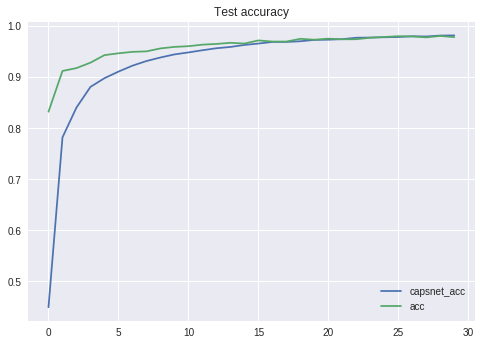

In [0]:

from matplotlib import pyplot as plt
import csv
import math
import pandas

def plot_log(filename_train, filename_test, show=True):

    data_train = pandas.read_csv(filename_train)
    data_test = pandas.read_csv(filename_test)

    for key in data_train.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data_train['epoch'].values, data_train[key].values, label=key)
    plt.legend()
    plt.title('Training accuracy')

    for key in data_test.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data_test['epoch'].values, data_test[key].values, label=key)
    plt.legend()
    plt.title('Test accuracy')

    plt.savefig('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/train_test_epoch_plot.png')
    if show:
        plt.show()
plot_log("/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/log.csv",
        "/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/every_epoch_test_accuracy.csv")